# Feature Selection

In [2]:
train_path = "data_train.csv"
validation_path = "data_validation.csv"

import pandas as pd
import numpy as np

df_train = pd.read_csv(train_path)
df_validation = pd.read_csv(validation_path)

nominal_columns = [
    'blue',
    'dual_sim',
    'four_g',
    'three_g',
    'touch_screen',
    'wifi',
    'price_range' # ordinal are included as well, target value
]

ratio_columns = [
    'battery_power',
    'clock_speed',
    'fc',
    'int_memory',
    'm_dep',
    'mobile_wt',
    'n_cores',
    'pc',
    'px_height',
    'px_width',
    'ram',
    'sc_h',
    'sc_w',
    'talk_time'
]

In [6]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

N = 10

# Assuming df_train is your training DataFrame and 'price_range' is the target
X = df_train.drop('price_range', axis=1)
y = df_train['price_range']

# Calculate mutual information
mi = mutual_info_classif(X, y)

# Make a DataFrame for better visualization
mi_df = pd.DataFrame(mi, index=X.columns, columns=['MI Score'])

# Sort features by their MI score
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

# Select top N features, you can decide N based on your requirements
selected_features = mi_df.head(N).index.tolist()

print(selected_features)

['ram', 'px_height', 'px_width', 'sc_h', 'battery_power', 'three_g', 'mobile_wt', 'int_memory', 'sc_w', 'fc']


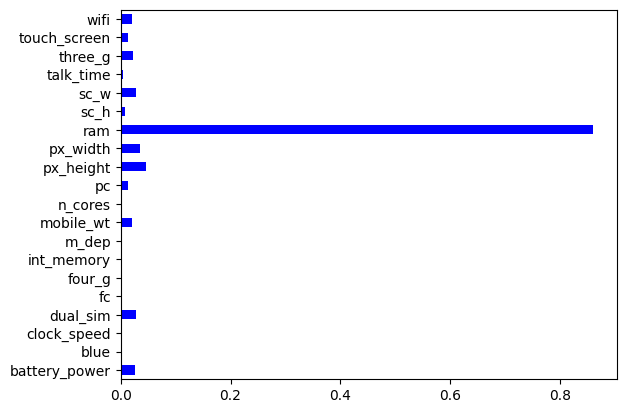

In [10]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

X = df_train.drop('price_range', axis=1)
Y = df_train['price_range']

%matplotlib inline
importances = mutual_info_classif(X,Y)
feat_importances = pd.Series(importances, df_train.columns[0:len(df_train.columns) - 1])
feat_importances.plot(kind='barh', color='blue')
plt.show()

price_range      1.000000
ram              0.918319
battery_power    0.184801
px_width         0.178713
px_height        0.158833
blue             0.041947
wifi             0.034329
three_g          0.027098
int_memory       0.026176
sc_w             0.019912
clock_speed      0.014031
sc_h             0.012149
talk_time        0.011113
m_dep            0.001205
four_g           0.000551
n_cores         -0.000582
fc              -0.003842
pc              -0.005214
dual_sim        -0.010756
touch_screen    -0.029842
mobile_wt       -0.074769
Name: price_range, dtype: float64


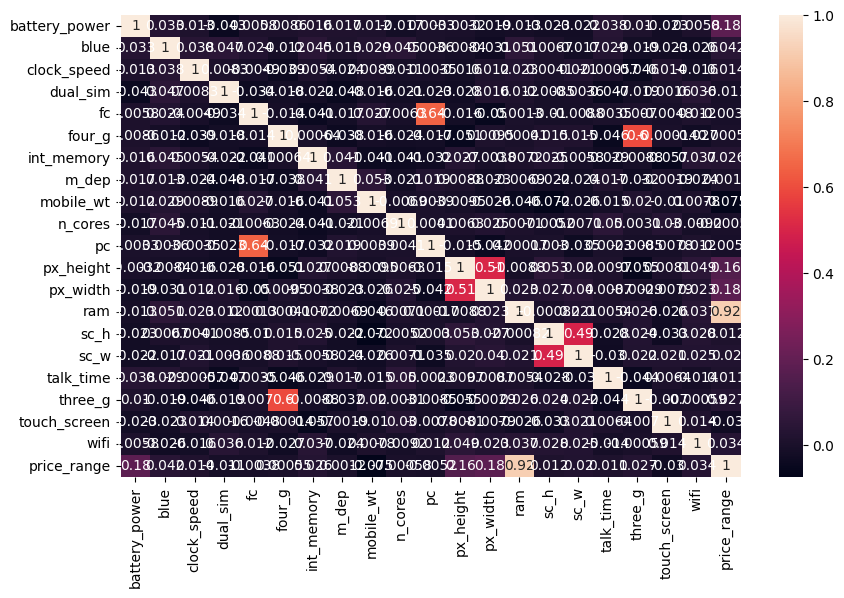

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cor = pd.read_csv(train_path).corr()

plt.figure(figsize = (10,6))
sns.heatmap(cor, annot = True)

cor_price_range = cor['price_range'].sort_values(ascending=False)
print(cor_price_range)

In [5]:
CONTINUOUS_VARIABLES = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
cor = []

for colName in CONTINUOUS_VARIABLES:
    corr = df_train[colName].corr(df_train['price_range'])
    cor.append(corr)
    print("Korelasi data %s dengan price_range: %s" %(colName, corr))

cor.sort(reverse=True)
print(cor)

Korelasi data battery_power dengan price_range: 0.184800924495531
Korelasi data clock_speed dengan price_range: 0.014031254818008095
Korelasi data fc dengan price_range: -0.0038420102981917303
Korelasi data int_memory dengan price_range: 0.026175706877841626
Korelasi data m_dep dengan price_range: 0.0012049180209846376
Korelasi data mobile_wt dengan price_range: -0.0747687504832367
Korelasi data pc dengan price_range: -0.005214430491653005
Korelasi data px_height dengan price_range: 0.15883273548307988
Korelasi data px_width dengan price_range: 0.17871269011026591
Korelasi data ram dengan price_range: 0.9183192307843847
Korelasi data sc_h dengan price_range: 0.012148883173074995
Korelasi data sc_w dengan price_range: 0.019911698810365034
Korelasi data talk_time dengan price_range: 0.01111273175475493
[0.9183192307843847, 0.184800924495531, 0.17871269011026591, 0.15883273548307988, 0.026175706877841626, 0.019911698810365034, 0.014031254818008095, 0.012148883173074995, 0.0111127317547549

# KNN

In [36]:
train_path = "data_train.csv"
validation_path = "data_validation.csv"

import pandas as pd
import numpy as np

df_train = pd.read_csv(train_path)
df_validation = pd.read_csv(validation_path)

nominal_columns = [
    'blue',
    'dual_sim',
    'four_g',
    'three_g',
    'touch_screen',
    'wifi'
]

ratio_columns = [
    'battery_power',
    'clock_speed',
    'fc',
    'int_memory',
    'm_dep',
    'mobile_wt',
    'n_cores',
    'pc',
    'px_height',
    'px_width',
    'ram',
    'sc_h',
    'sc_w',
    'talk_time'
]

columns = nominal_columns + ratio_columns

x_train = df_train.drop(['price_range'], axis=1)
y_train = df_train['price_range'].apply(int)

x_validation = df_validation.drop(['price_range'], axis=1)
y_validation = df_validation['price_range']


In [61]:
from pandas import DataFrame, Series
from typing import List, Dict
import json

class KNNClassifier:
    n_neighbors: int
    features: DataFrame = None
    target: Series = None
    nominal_columns: List[str]
    numeric_columns: List[str]
    column_correlations : Dict
    standardize : bool
    multiply_correlations : bool

    def __init__(self, standardize : bool = False, n_neighbors=5, multiply_correlations : bool = True):
        '''
            Parameters:
                standardize (bool) : Apakah data latihan akan dinormalisasi
                n_neighbors (int) : Jumlah tetangga yang digunkan saat prediksi
                multiply_correlations (bool) : Apakah besar korelasi dari sebuah kolom diperhitungkan pada kolom target
        '''
        self.n_neighbors = n_neighbors
        self.standardize = standardize
        self.multiply_correlations = multiply_correlations

    def fit(self, x: DataFrame, y: Series, categorical_column: List[str] = []):
        '''
        Melatih model yang diinstansiasi dengan data latihan yang diberikan dan konfigurasi 

            Parameters:
                x (Dataframe) : Data latihan tanpa label
                y (Series) : Label dari data latihan (target)
                categorical_column (List[str]) : Kolom dari x yang bertipe kategorikal
        '''
        self.features = x
        self.target = y
        self.nominal_columns = categorical_column
        self.numeric_columns = list(set(x.columns).difference(self.nominal_columns))
        self.column_correlations = dict()
        
        if self.standardize:
            self.features = self._standardize_data(self.features, self.numeric_columns)
        self._get_correlation()
        print(self.column_correlations)

    def save_model(self, feature_path = 'features.csv', target_path = 'target.csv', conf_path = 'conf.json'):
        '''
        Save the model to the given files
        '''
        self.features.to_csv(feature_path)
        self.target.to_csv(target_path)
        conf_json = json.dumps({
            "nominal_columns" : self.nominal_columns,
            "standardize" : self.standardize,
            "multiply_correlations" : self.multiply_correlations,
            "n_neighbors" : self.n_neighbors
        }, indent=4)
        with open(conf_path, "w") as f:
            f.write(conf_json)
    
    def load_model(self,feature_path = 'features.csv', target_path = 'target.csv', conf_path = 'conf.json'):
        '''
        Load the model from the given files
        '''
        x = pd.read_csv(feature_path, index_col=0)
        y = pd.read_csv(target_path)
        target_column = y.columns[1]
        y = y[target_column]
        with open(conf_path, "r") as f:
            conf_json = json.load(f)
            self.n_neighbors = conf_json["n_neighbors"]
            self.standardize = conf_json["standardize"]
            self.multiply_correlations = conf_json["multiply_correlations"]

        self.fit(x, y, conf_json["nominal_columns"])

    def _get_correlation(self):
        '''
        Mendapatkan korelasi dari setiap kolom yang ada pada data latihan dengan label, kemudian menyimpannya ke atribut column_correlations dari instans
        '''
        columns = self.numeric_columns + self.nominal_columns
        target_column = self.target
        for column in columns:
            self.column_correlations[column] = 2**(self.features[column].corr(target_column))

    def _standardize_data(self, df: DataFrame, columns: List[str]):
        '''
        Melakukan standarisasi dari data yang diberikan pada kolom yang diberikan dari data tersebut, lalu mengembalikan hasilnya
        
        Parameters:
                df (Dataframe) : Data yang ingin dinormalisasi
                columns (List[str]) : Kolom dari df yang ingin dinormalisasi

        Returns:
                df_standardized (Dataframe): salinan dari df yang telah dinormalisasi pada kolom yang diberikan
        '''
        df_standardized = df.copy()

        for col in columns:
            mean = df[col].mean()
            std = df[col].std()
            df_standardized[col] = (df[col] - mean)/std 

        return df_standardized
        

    def _calculate_distance(self, row: Series) -> np.ndarray:
        '''
        Menghitung jarak dari baris yang diberikan
        Data diasumsikan data sudah termornalisasi sehingga kolom numerik dan kategorikal bisa dianggap sama perhitungannya
        Jika multiply_correlations dari instans adalah True, maka korelasi dari kolom yang ada dengan target akan diperhitungkan dengan dikalikan pada jarak
        Parameters:
                y (Series) : Label dari data latihan (target)
        Returns:
                result (int): Jarak dari baris yang diberikan
        '''
        if self.multiply_correlations:
            result = (((self.features - row)**2).mul(self.column_correlations)).sum(axis=1).pow(1/2)
        else :
            result = ((self.features - row)**2).sum(axis=1).pow(1/2)
        
        return result
    
    def multiplied(self):
        return ((self.features)).mul(self.column_correlations)
    
    def _predict_row(self, row: Series):
        '''
        Memprediksi nilai label dari baris yang diberikan lalu mengembalikan hasilnya
            Parameters:
                row (Series) : Baris data yang ingin diprediksi nilai labelnya
            Returns:
                result (int): Prediksi nilai label untuk baris yang diberikan
        '''
        distance = self._calculate_distance(row)
        
        data = pd.DataFrame(data={
            "distance": distance,
            "target": self.target
        }).sort_values(by=['distance'], ascending=True)
        result = round(data['target'][:self.n_neighbors].mean())
        # result = data['target'][:self.n_neighbors].mode()[0]

        return result
    
    def predict(self, to_predict: DataFrame):
        '''
        Memprediksi nilai label dari baris yang diberikan lalu mengembalikan hasilnya
            Parameters:
                to_predict (Dataframe) : Data validasi yang ingin diprediksi nilai labelnya
            Returns:
                result (array of int): Nilai label hasil prediksi untuk data yang diberikan, terurut sesuai tiap baris pada data
        '''
        if self.standardize :
            to_predict = self._standardize_data(to_predict, self.numeric_columns)

        prediction_result = []

        for (i, row) in to_predict.iterrows():
            prediction_result.append(self._predict_row(row))

        return prediction_result
        


In [42]:
def accuracy_score(y_real, y_test):
    correct = 0

    for i in range(len(y_real)):
        if y_real[i] == y_test[i]:
            correct += 1

    return correct / len(y_real)

In [63]:
neighbours_used = 17

model1 = KNNClassifier(True, neighbours_used, True)
model2 = KNNClassifier(False, neighbours_used, True)
model3 = KNNClassifier(True, neighbours_used, False)
model4 = KNNClassifier(False, neighbours_used, False)

# model1.fit(x_train, y_train, nominal_columns)
model2.fit(x_train, y_train, nominal_columns)

model2.save_model()
# model3.fit(x_train, y_train, nominal_columns)
# model4.fit(x_train, y_train, nominal_columns)

model3.load_model()


# model2.multiplied()

# print("Correlation accounted, standardized, accuracy :", accuracy_score(y_validation, model1.predict(x_validation)))
print("Correlation accounted, not standardized, accuracy :", accuracy_score(y_validation, model2.predict(x_validation)))
print("Correlation accounted, not standardized, accuracy :", accuracy_score(y_validation, model3.predict(x_validation)))
# print("Correlation not accounted, standardized, accuracy :", accuracy_score(y_validation, model3.predict(x_validation)))
# print("Correlation not accounted, not standardized, accuracy :", accuracy_score(y_validation, model4.predict(x_validation)))

{'mobile_wt': 0.9494943031484544, 'fc': 0.9973404642422978, 'int_memory': 1.0183092128319688, 'talk_time': 1.0077325012473515, 'px_width': 1.131873469281212, 'ram': 1.889912224013501, 'battery_power': 1.1366601162478973, 'sc_w': 1.013897421568552, 'n_cores': 0.9995964406186718, 'px_height': 1.1163835221700165, 'sc_h': 1.0084565201720506, 'pc': 0.9963921561713885, 'm_dep': 1.0008355343936008, 'clock_speed': 1.0097731732765796, 'blue': 1.0295021826306285, 'dual_sim': 0.9925721195086483, 'four_g': 1.0003818919673215, 'three_g': 1.018960148121211, 'touch_screen': 0.9795272409131484, 'wifi': 1.0240806645050748}
{'mobile_wt': 0.9494943031484544, 'fc': 0.9973404642422978, 'int_memory': 1.0183092128319688, 'talk_time': 1.0077325012473515, 'px_width': 1.131873469281212, 'ram': 1.889912224013501, 'battery_power': 1.1366601162478973, 'sc_w': 1.013897421568552, 'n_cores': 0.9995964406186718, 'px_height': 1.1163835221700165, 'sc_h': 1.0084565201720506, 'pc': 0.9963921561713885, 'm_dep': 1.000835534

In [8]:
kaggle_test = pd.read_csv("kaggle_test.csv").drop(['id'], axis=1)

In [9]:
model_submission = KNNClassifier(False, 17, True)

model_submission.fit(x_train, y_train, nominal_columns)

result = model_submission.predict(kaggle_test)

result_df = pd.DataFrame({"price_range" : result})
train_df_processed = pd.DataFrame({"price_range" : y_train})

In [10]:
result_df.index = pd.RangeIndex(len(result_df.index))

result_df['id'] = result_df.index

result_df.to_csv("submission_mean.csv", columns=['id', 'price_range'], index=False)

result_df

,price_range,id
0,0,0
1,3,1
2,3,2
3,2,3
4,0,4
...,...,...
1995,2,1995
1996,0,1996
1997,3,1997
1998,0,1998


hasil percobaan algoritma ini (dan algoritma yang sudah jadi)

kenapa setiap kali standarisasi akurasinya malah menurun jauh?

TODO KNN

coba coba pake algoritma yg lebih canggih? buat sebagai opsi di parameter, jgn timpa algoritma lama

mekanisma penyimpanan? KNN tidak ada hipotesis jadi apa yg disimpan

# Naive Bayes

In [33]:
train_path = "data_train.csv"
validation_path = "data_validation.csv"

import pandas as pd
import numpy as np

df_train = pd.read_csv(train_path)
df_validation = pd.read_csv(validation_path)

nominal_columns = [
    'blue',
    'dual_sim',
    'four_g',
    'three_g',
    'touch_screen',
    'wifi'
]


ratio_columns = [
    'battery_power',
    'clock_speed',
    'fc',
    'int_memory',
    'm_dep',
    'mobile_wt',
    'n_cores',
    'pc',
    'px_height',
    'px_width',
    'ram',
    'sc_h',
    'sc_w',
    'talk_time'
]


x_train = df_train.drop(['price_range'], axis=1)
y_train = df_train['price_range']

x_validation = df_validation.drop(['price_range'], axis=1)
y_validation = df_validation['price_range']

hei


In [34]:
from pandas import DataFrame, Series
import json
import math

class NaiveBayesClassifier:
    df_train: DataFrame

    def __init__(self, smoothing : bool = True):
        '''
            Parameters:
                smoothing (bool) : Apakah pelatihan data menggunakan smoothing
        '''
        self.is_smoothing = smoothing
        self.smoothing_factor = 2  # Laplace smoothing factor
        self.result_dict = {}
        
    # Gaussian Probability
    def _calculate_gaussian_pdf(self, feature, mean, std):
        '''
            Mengkalkulasi nilai gaussian berdasarkan fitur, mean, dan standar deviasi
        '''
        e = math.exp(-((feature - mean)**2)/(2*std**2))
        return (1/(math.sqrt(2*math.pi)*std)) * e
    
    def _calculate_probabilities(self):
        '''
            Mengkalkulasi probabilitas setiap fitur
        '''
        for feature_column in self.df_train.columns.drop('price_range'):
            if feature_column in nominal_columns:  # Replace with actual nominal columns
                grouped_data = self.df_train.groupby(['price_range', feature_column]).size().reset_index(name='occurrence')
                for _, row in grouped_data.iterrows():
                    price_range_val = str(row['price_range'])
                    feature_val = row[feature_column]
                    occurrence_val = row['occurrence']

                    if price_range_val not in self.result_dict:
                        self.result_dict[price_range_val] = {}
                    if feature_column not in self.result_dict[price_range_val]:
                        self.result_dict[price_range_val][feature_column] = {}

                    # Laplace Smoothing
                    self.result_dict[str(price_range_val)][feature_column][feature_val] = \
                        (occurrence_val + self.smoothing_factor) / (self.prior[int(price_range_val)] * len(self.df_train) + self.smoothing_factor * len(self.df_train[feature_column].unique()))
    
    def _convert_keys_to_string(self, dictionary):
        '''
            Fungsi utilitas untuk mengubah keyvalue integer ke string
        '''
        if isinstance(dictionary, dict):
            return {str(key): self._convert_keys_to_string(value) for key, value in dictionary.items()}
        else:
            return dictionary
    
    def _print_to_json(self):
        '''
            Menyimpan model yang telah dibuat ke dalam file berbentuk JSON
        '''
        self.means.to_json('means.json', indent=4)
        self.vars.to_json('variance.json', indent=4)
        self.prior.to_json('prior.json', indent=4)
        with open('result_dict.json', 'w') as json_file:
            json.dump(self._convert_keys_to_string(self.result_dict), json_file, indent=4)
        with open('nominal_unique_counts.json', 'w') as file:
                json.dump(self.nominal_unique_counts, file, indent=4)
    
    def fit(self, x: DataFrame, y: Series, save : bool):
        '''
        Melatih model yang diinstansiasi dengan data latihan yang diberikan
            Parameters:
                x (Dataframe) : Data latihan tanpa label
        '''

        self.df_train = x
        self.df_train['price_range'] = y
        self.means = self.df_train.groupby('price_range').mean()
        self.vars = self.df_train.groupby('price_range').var()
        self.prior = (self.df_train.groupby('price_range').count() / len(self.df_train)).iloc[:, 0]
        self.classes = np.unique(y)
        self.result_dict = {}
        self._calculate_probabilities()
        self.nominal_unique_counts = {col: x[col].nunique() for col in nominal_columns}
        
        #printing
        if save:
            self._print_to_json()

    def fit_from_json(self, means_file: str, variance_file: str, prior_file: str, result_dict_file: str, nominal_unique_counts_file:str):
        '''
            Mengkonfigurasi model berdasarkan masukan JSON File Path yang diterima
            Parameters:
                means_file (String) : Pathname untuk nilai mean
                variance_file (String) : Pathname untuk nilai string
                prior_file (String) : Pathname untuk probabilitas setiap target class
                result_dict_file (String) : Pathname untuk hasil probabilitas setiap kolom
                nominal_unique_counts (String) : Pathname untuk jumlah setiap kolom nominal
        '''
        self.means = pd.read_json(means_file)
        self.vars = pd.read_json(variance_file)
        self.prior = pd.read_json(prior_file, typ='series')
        with open(result_dict_file, 'r') as file:
            self.result_dict = json.load(file)
        with open(nominal_unique_counts_file, 'r') as file:
            self.nominal_unique_counts = json.load(file)
        self.classes = self.means.index.unique()
        

    def predict(self, to_predict: DataFrame):
        '''
            Memprediksi nilai label dari baris yang diberikan lalu mengembalikan hasilnya
            Parameters:
                to_predit (Dataframe) : Data validasi yang ingin diprediksi
            Returns:
                predictions (array of int) : Nilai label hasil prediksi untuk data yang diberikan, terurut setiap baris pada data
        '''
        predictions = []
        for i in to_predict.index:
            class_likelihood = []
            instance = to_predict.loc[i]
            for cls in self.classes:
                feature_likelihood = [self.prior.loc[cls]]
                for col in to_predict.columns:
                    data = instance[col]
                    if col in ratio_columns:
                        mean = self.means[col].loc[cls]
                        variance = self.vars[col].loc[cls]
                        likelihood = self._calculate_gaussian_pdf(data, mean, np.sqrt(variance))
                        feature_likelihood.append(likelihood) 
                    elif col in nominal_columns:
                        likelihood = self.result_dict[str(cls)][col].get(data, self.smoothing_factor / (self.prior[cls] * len(to_predict) + self.smoothing_factor * self.nominal_unique_counts[col]))
                        feature_likelihood.append(likelihood) 
                    
                # print(feature_likelihood)
                class_likelihood.append(np.prod(feature_likelihood))
            predictions.append(np.argmax(class_likelihood))
        return predictions

In [64]:
from sklearn.metrics import accuracy_score
selected_features = [
    'three_g',
    'battery_power',
    'fc',
    'int_memory',
    'mobile_wt',
    'px_height',
    'px_width',
    'ram',
    'sc_h',
    'sc_w',
]

df_train = df_train

model = NaiveBayesClassifier(True)
train = model.fit(x_train, y_train, True)
# train = model.fit_from_json('means.json', 'variance.json','prior.json','result_dict.json', 'nominal_unique_counts.json')
results = model.predict(x_validation)

accuracy = accuracy_score(y_validation, results)
print(accuracy)

0.7816666666666666


# Bonus

In [13]:
train_path = "data_train.csv"
validation_path = "data_validation.csv"

import pandas as pd
import numpy as np

df_train = pd.read_csv(train_path)
df_validation = pd.read_csv(validation_path)

nominal_columns = [
    'blue',
    'dual_sim',
    'four_g',
    'three_g',
    'touch_screen',
    'wifi',
    'price_range' # ordinal are included as well, target value
]

ratio_columns = [
    'battery_power',
    'clock_speed',
    'fc',
    'int_memory',
    'm_dep',
    'mobile_wt',
    'n_cores',
    'pc',
    'px_height',
    'px_width',
    'ram',
    'sc_h',
    'sc_w',
    'talk_time'
]

In [14]:
from typing import List

def standardize_data(df: pd.DataFrame, columns: List[str]):
        '''
        Melakukan standarisasi dari data yang diberikan pada kolom yang diberikan dari data tersebut, lalu mengembalikan hasilnya
        
        Parameters:
                df (Dataframe) : Data yang ingin dinormalisasi
                columns (List[str]) : Kolom dari df yang ingin dinormalisasi

        Returns:
                df_standardized (Dataframe): salinan dari df yang telah dinormalisasi pada kolom yang diberikan
        '''
        df_standardized = df.copy()

        for col in columns:
            mean = df[col].mean()
            std = df[col].std()
            df_standardized[col] = (df[col] - mean)/std 

        return df_standardized

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, BernoulliNB

x_train = df_train.drop(['price_range'], axis=1)
y_train = df_train['price_range']

x_train_standardized = standardize_data(x_train, ratio_columns)

x_validation = df_validation.drop(['price_range'], axis=1)
y_validation = df_validation['price_range']

# TEST WITH KNN
model = KNeighborsClassifier(n_neighbors=17, weights='distance')
model.fit(x_train, y_train)
knn_accuracy = accuracy_score(y_validation, model.predict(x_validation))

print(f"KNN Accuracy {knn_accuracy}")

# TEST WITH KNN : Normalized
model = KNeighborsClassifier(n_neighbors=17, weights='distance')
model.fit(x_train_standardized, y_train)
knn_accuracy = accuracy_score(y_validation, model.predict(standardize_data(x_validation, ratio_columns)))

print(f"KNN Normalized Accuracy {knn_accuracy}")

# TEST WITH NAIVE BAYES (Gaussian)
model_gaussian = GaussianNB()
model_gaussian.fit(x_train, y_train)
gaussian_accuracy = accuracy_score(y_validation, model_gaussian.predict(x_validation))
print(f"Gaussian accuracy {gaussian_accuracy}")

# Test with Naive Bayes (Multinomial)
model_multinomial = MultinomialNB()
model_multinomial.fit(x_train, y_train)
multinomial_acc = accuracy_score(y_validation, model_multinomial.predict(x_validation))
print(f"Multinomial accuracy {multinomial_acc}")

# Test with Naive Bayes (Categorical)
model_categorical = CategoricalNB()
model_categorical.fit(x_train, y_train)
categorical_acc = accuracy_score(y_validation, model_categorical.predict(x_validation))
print(f"Categorical accuracy {categorical_acc}")


# Test with Naive Bayes (Multinomial)
model_bernoulli = BernoulliNB()
model_bernoulli.fit(x_train, y_train)
bernoulli_acc = accuracy_score(y_validation, model_bernoulli.predict(x_validation))
print(f"Bernoulli accuracy {bernoulli_acc}")

KNN Accuracy 0.9366666666666666
KNN Normalized Accuracy 0.685
Gaussian accuracy 0.7816666666666666
Multinomial accuracy 0.5316666666666666
Categorical accuracy 0.2966666666666667
Bernoulli accuracy 0.23333333333333334
